# Experiment: Varying N in top-N DDA fragmentation

We demonstrate that the simulator can be used for scan-level closed-loop DDA experiments. 
- Take an existing data. Find out which MS1 peaks are linked to which MS2 peaks.
- Run all MS1 peaks through the simulator’s Top-N protocol. 
- For the top-100 most intense MS1 peaks, how many got fragmented in the simulator as we change N?
- If N is greater than the real data, do we see the same MS1 peaks from (1) being fragmented again, plus additional fragment peaks?
- Verification on actual machine.
- Talk to stefan about machine time.

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import sys
import scipy.stats
import pylab as plt
from IPython import display
import pylab as plt
from random import random, shuffle
from joblib import Parallel, delayed
import multiprocessing

In [4]:
sys.path.append('../codes')

In [5]:
from VMSfunctions.Chemicals import *
from VMSfunctions.Chromatograms import *
from VMSfunctions.MassSpec import *
from VMSfunctions.Controller import *
from VMSfunctions.Common import *
from VMSfunctions.DataGenerator import *
from VMSfunctions.Noise import *

### Load densities trained on 4 beer data (see [loader_kde](loader_kde.ipynb)).

In [6]:
ps = load_obj('../models/peak_sampler_4_beers.p')

### Load chromatogram data exported from the real data (BEER1POS)

Correct the positively charged ions by substracting the mass of a proton

In [7]:
def f(peak_mz, chrom_mzs):
    peak_mz = peak_mz - PROTON_MASS
    chrom_mzs = chrom_mzs - PROTON_MASS
    return peak_mz, chrom_mzs

In [8]:
xcms_output = '../models/beer1pos_ms1_peaks.csv.gz'
cc = ChromatogramCreator(xcms_output, correction_func=f)

DEBUG:Chemicals:Loading 0 chromatograms
../codes\VMSfunctions\Common.py:58: RuntimeWarning:

divide by zero encountered in double_scalars

DEBUG:Chemicals:Loading 5000 chromatograms
DEBUG:Chemicals:Loading 10000 chromatograms


Turn the loaded data into `UnknownChemical` objects.

In [9]:
min_ms1_intensity = 2E5
min_rt = 3*60
max_rt = 21*60
chemicals = ChemicalCreator(ps)
dataset = chemicals.sample_from_chromatograms(cc, min_rt, max_rt, min_ms1_intensity, ms_levels=2)

DEBUG:Chemicals:11340 ms1 peaks to be created.
DEBUG:Chemicals:i = 0
DEBUG:Chemicals:i = 2500
DEBUG:Chemicals:i = 5000


In [10]:
len(dataset)

5821

### Add noise

Create region of interest objects

In [11]:
mzml_path = 'C:\\Users\\joewa\\University of Glasgow\\Vinny Davies - CLDS Metabolomics Project\\Data\\Beers_4Beers_compared\\Positive\\samples\\mzML'
xcms_roi_file = 'C:\\Users\\joewa\\University of Glasgow\\Vinny Davies - CLDS Metabolomics Project\\Data\\Beers_4Beers_compared\\rois.csv'
extracted_roi_file = '../models/all_rois.p'

ds = DataSource()
ds.load_data(mzml_path)

INFO:DataGenerator:Loading Beer_1_full1.mzML
INFO:DataGenerator:Loading Beer_1_full2.mzML
INFO:DataGenerator:Loading Beer_1_full3.mzML
INFO:DataGenerator:Loading Beer_2_full1.mzML
INFO:DataGenerator:Loading Beer_2_full2.mzML
INFO:DataGenerator:Loading Beer_2_full3.mzML
INFO:DataGenerator:Loading Beer_3_full1.mzML
INFO:DataGenerator:Loading Beer_3_full2.mzML
INFO:DataGenerator:Loading Beer_3_full3.mzML
INFO:DataGenerator:Loading Beer_QC_full1.mzML
INFO:DataGenerator:Loading Beer_QC_full2.mzML
INFO:DataGenerator:Loading Beer_QC_full3.mzML


In [12]:
ds.extract_roi(xcms_roi_file)
ds.save_roi(extracted_roi_file)

INFO:DataGenerator:Creating ROI objects for Beer_1_full1.mzML
DEBUG:DataGenerator:     0/394970
DEBUG:DataGenerator: 50000/394970
DEBUG:DataGenerator:100000/394970
DEBUG:DataGenerator:150000/394970
DEBUG:DataGenerator:200000/394970
DEBUG:DataGenerator:250000/394970
DEBUG:DataGenerator:300000/394970
DEBUG:DataGenerator:350000/394970
INFO:DataGenerator:Populating ROI objects for Beer_1_full1.mzML
DEBUG:DataGenerator:     0/  1112 processing spectrum <__main__.Spectrum object with native ID 1 at 0x23ba58655f8>
DEBUG:DataGenerator:   100/  1112 processing spectrum <__main__.Spectrum object with native ID 201 at 0x23ba5ad46d8>
DEBUG:DataGenerator:   200/  1112 processing spectrum <__main__.Spectrum object with native ID 401 at 0x23ba5d29710>
DEBUG:DataGenerator:   300/  1112 processing spectrum <__main__.Spectrum object with native ID 601 at 0x23ba5f7a748>
DEBUG:DataGenerator:   400/  1112 processing spectrum <__main__.Spectrum object with native ID 801 at 0x23ba61c97f0>
DEBUG:DataGenerator

In [13]:
ds.load_roi(extracted_roi_file)    

In [14]:
filename = list(ds.all_rois.keys())[0]

In [15]:
filename

'Beer_1_full1.mzML'

Add a whole bunch of `UnknownChemicals` with chromatograms coming from non-peak ROIs from Beer1Pos

In [16]:
nc = NoisyRoiCreator(ps, ds, filename)

In [17]:
len(nc.false_rois)

316830

Added 9000 small non-peaks regions of interests

In [18]:
def plot_chems(chem_list, N=10):
    for c in chem_list[0:N]:
        chrom = c.chromatogram
        plt.plot(chrom.raw_rts, chrom.raw_intensities)
        plt.show()

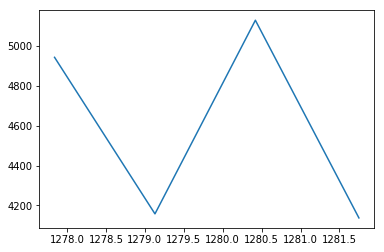

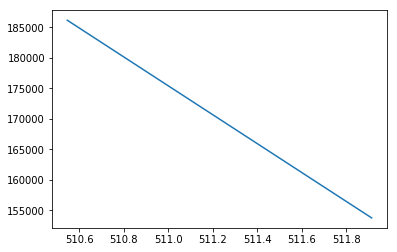

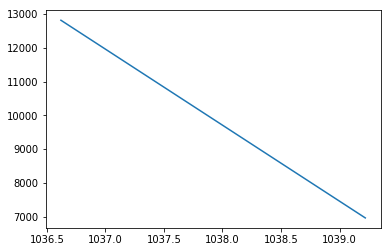

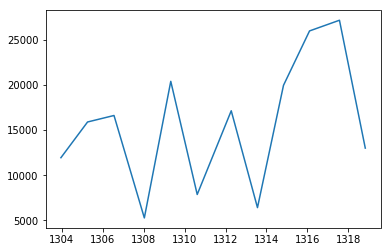

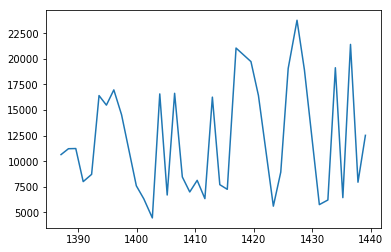

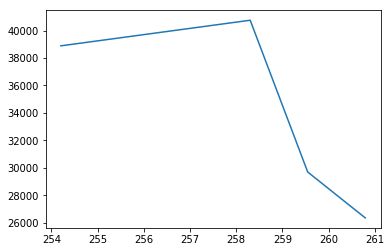

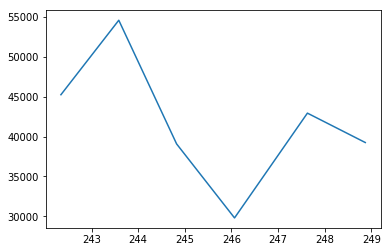

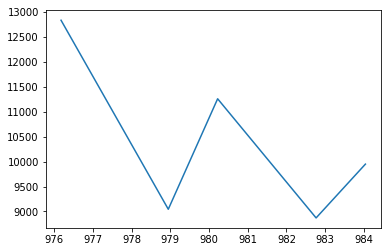

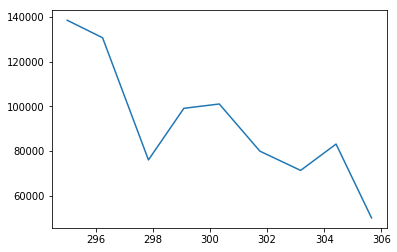

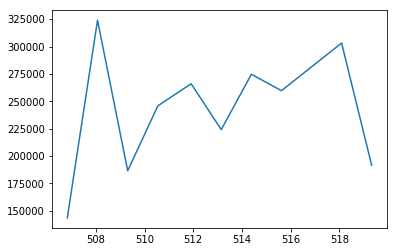

In [19]:
rois = nc.sample(9000, ms_levels=2, min_num_scans=5)
plot_chems(rois)

Add 1000 large non-peaks regions of interest

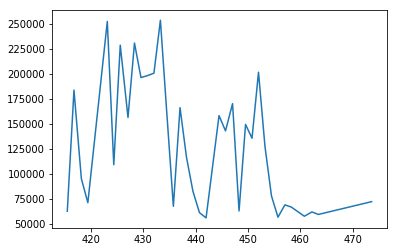

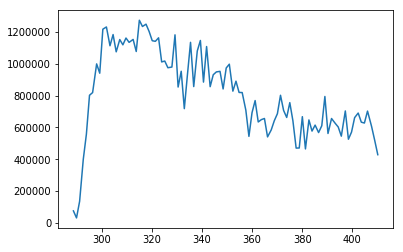

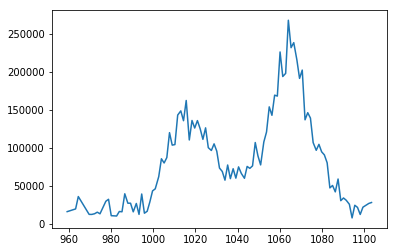

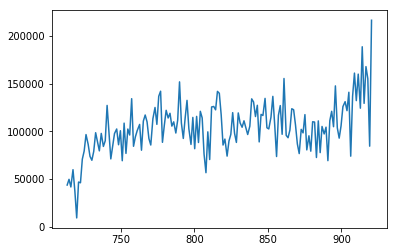

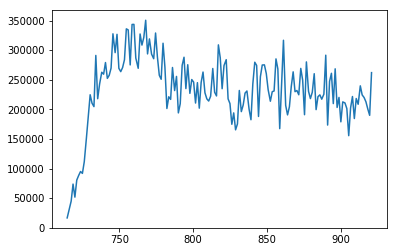

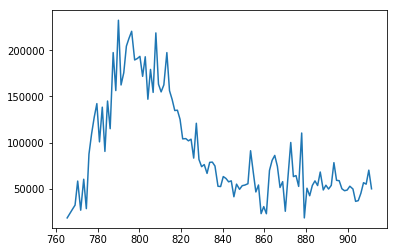

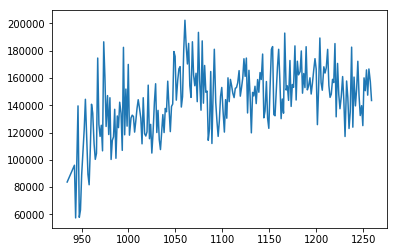

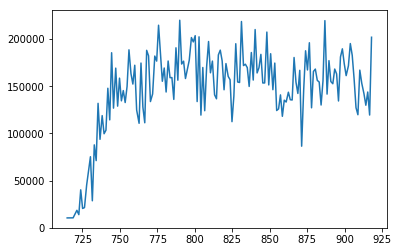

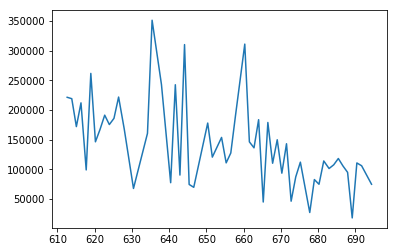

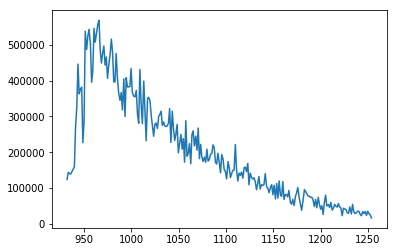

In [20]:
large_rois = nc.sample(1000, ms_levels=2, min_num_scans=50, 
                         min_rt=min_rt, max_rt=max_rt, min_ms1_intensity=min_ms1_intensity)
plot_chems(large_rois)

In [21]:
noisy_dataset = dataset + rois + large_rois

In [22]:
shuffle(noisy_dataset)

In [23]:
len(dataset)

5821

In [24]:
len(noisy_dataset)

15821

### Experiment by varying N

In [25]:
N = 10                   # top-5 DDA fragmentation
isolation_window = 0.5   # the isolation window in Dalton around a selected precursor ion
rt_tol = 5               # the rt window around a selected precursor ion to prevent it from fragmented multiple times

In [26]:
set_log_level_warning()
# set_log_level_info()
# set_log_level_debug()

Run serially

In [43]:
controllers = []
inputs = range(5, 105, 5) 
for N in inputs:
    print('N =', N)
    mass_spec = IndependentMassSpectrometer(POSITIVE, noisy_dataset, density=ps.density_estimator)
    controller = TopNController(mass_spec, N, isolation_window, rt_tol)
    controller.make_plot = False    
    controller.run(min_rt, max_rt)
    controllers.append(controller)

N = 5


1080.040702898436it [23:59,  1.33s/it]                                                                                            


N = 10


1080.133641810415it [20:43,  1.04it/s]                                                                                            


N = 15


1080.0982279438467it [16:57,  1.14s/it]                                                                                           


N = 20


1080.1247243465045it [13:43,  1.31it/s]                                                                                           


N = 25


1080.134677888717it [11:16,  1.60it/s]                                                                                            


N = 30


1080.114242550983it [10:01,  1.80it/s]                                                                                            


N = 35


1080.0377722382436it [09:47,  1.84it/s]                                                                                           


N = 40


1080.0784022847613it [09:32,  1.89it/s]                                                                                           


N = 45


1080.1952982857927it [09:45,  1.55it/s]                                                                                           


N = 50


1080.0864027458194it [10:39,  1.63it/s]                                                                                           


N = 55


1080.0906908330771it [10:13,  2.10it/s]                                                                                           


N = 60


1080.0649943066817it [10:39,  1.67it/s]                                                                                           


N = 65


1080.1055944664724it [10:59,  1.51it/s]                                                                                           


N = 70


1080.0893246179455it [09:45,  1.54it/s]                                                                                           


N = 75


1080.0814211007469it [10:09,  1.55it/s]                                                                                           


N = 80


1080.1006009487464it [09:41,  1.86it/s]                                                                                           


N = 85


1080.1682573555634it [10:16,  1.66it/s]                                                                                           


N = 90


1080.0900968103472it [10:16,  1.84it/s]                                                                                           


N = 95


1080.1642941574578it [09:57,  1.89it/s]                                                                                           


N = 100


1080.2245054568994it [09:48,  1.73it/s]                                                                                           


Run in parallel

In [44]:
# inputs = range(5, 105, 5) 
# def processInput(N):
#     mass_spec = IndependentMassSpectrometer(POSITIVE, noisy_dataset, density=ps.density_estimator)
#     controller = TopNController(mass_spec, N, isolation_window, rt_tol)
#     controller.run(min_rt, max_rt, progress_bar=False)
#     return controller

# num_cores = multiprocessing.cpu_count()
# controllers = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)
# print(controllers)

Write to mzML files

In [45]:
for controller in controllers:
    N = controller.N
    analysis_name = 'Top-%d Analysis' % N
    outfile = '../models/noisy_top_%d.mzML' % N    
    controller.write_mzML(analysis_name, outfile)

In [57]:
save_obj(controllers, '../models/noisy_top_N_controllers.p', use_joblib=False)

TypeError: can't pickle _thread.RLock objects

Plot total number of fragmented MS2 peaks

In [46]:
def get_total_peaks(controller, ms_level):
    num_peaks = [scan.num_peaks for scan in controller.scans[ms_level]]
    return sum(num_peaks)

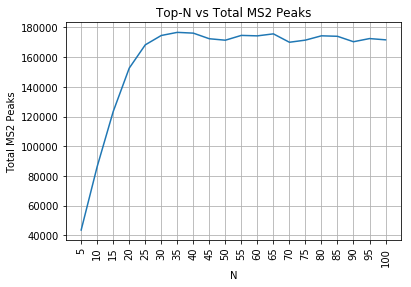

In [55]:
total_peaks = [get_total_peaks(controller, 2) for controller in controllers]
plt.plot(total_peaks)
plt.xlabel('N')
plt.ylabel('Total MS2 Peaks')
plt.title('Top-N vs Total MS2 Peaks')
plt.xticks(range(len(inputs)), inputs, rotation='vertical')
plt.grid()

Plot how many large MS1 peaks got fragmented

In [ ]:
sorted_dataset = sorted(dataset, key=lambda x: x.max_intensity, reverse=True)
most_intense = sorted_dataset[0:100]